## Recommendation System MOVIELENS - 100K
---

In [1]:
import numpy as np
import pandas as pd
import altair as alt
import collections
import sklearn
import sklearn.manifold
from IPython import display
import tensorflow.compat.v1 as tf
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt

2021-09-02 09:36:20.034945: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

Instructions for updating:
non-resource variables are not supported in the long term


In [45]:
USER_RATINGS = False

In [4]:
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

In [5]:
def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

In [6]:
pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [7]:
def mark_genres(movies, genres):
    def get_random_genre(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if(len(active) == 0):
            return 'Other'
        return np.random.choice(active)
    
    def get_all_genres(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if(len(active) == 0):
            return 'Other'
        return '_'.join(active)

    movies['genre'] = [get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
    movies['all_genres'] = [get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

In [52]:
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
        df: a dataframe.
        holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
        train: dataframe for training
        test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
        
    return train, test

In [9]:
def filtered_hist(field, label, filter):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')

### Data Loading and Threatment  
---

>- Full dataset rating users 943 users and 1682 items.

In [10]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('data/u.data', names=ratings_cols, sep='\t')
ratings.head()

user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

>- Users information dataset.

In [11]:
user_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('data/u.user', names=user_cols, sep='|')
users.head()

user_id  age sex  occupation zip_code
0        1   24   M  technician    85711
1        2   53   F       other    94043
2        3   23   M      writer    32067
3        4   24   M  technician    43537
4        5   33   F       other    15213

>- Item information dataset.

In [12]:
items_cols = ['movie_id', 'movie_title', 'release_date', 'video_realease_date', 'IMDb_URL',
            'unknown', 'Action', 'Adventure', 'Animation', "Children\'s", 'Comedy', 'Crime', 'Documentary', 
            'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Thriller',
            'War', 'Western']
items = pd.read_csv('data/u.item', names=items_cols, encoding='latin', sep='|')
items.head()

movie_id        movie_title release_date  video_realease_date  \
0         1   Toy Story (1995)  01-Jan-1995                  NaN   
1         2   GoldenEye (1995)  01-Jan-1995                  NaN   
2         3  Four Rooms (1995)  01-Jan-1995                  NaN   
3         4  Get Shorty (1995)  01-Jan-1995                  NaN   
4         5     Copycat (1995)  01-Jan-1995                  NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children's  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1           1  ...        0          0       0        0   
1          1          0           0  ...        0          0       0        0   
2          0          0           0  ...        0          0       0        0   
3          0          0           0  ...        0          0       0        0   
4          0          0           0  ...        0          0       0        0   

   Mystery  Romance  Sci-Fi  Thriller  War  Western  
0        0        0       0         0    0        0  
1        0        0       0         1    0        0  
2        0        0       0         1    0        0  
3        0        0       0         0    0        0  
4        0        0       0         1    0        0  

[5 rows x 24 columns]

>- Genre information dataset.

In [13]:
genres = pd.read_csv('data/u.genre', index_col=1, names=['names'], sep='|')
genres.head()

names
0     unknown
1      Action
2   Adventure
3   Animation
4  Children's

### Data Threatment
---

- Since the `ids` on the dataset start at 1, we subtract 1 from all the ids in order to avoid some problems.

In [14]:
ratings

user_id  movie_id  rating  timestamp
0          196       242       3  881250949
1          186       302       3  891717742
2           22       377       1  878887116
3          244        51       2  880606923
4          166       346       1  886397596
...        ...       ...     ...        ...
99995      880       476       3  880175444
99996      716       204       5  879795543
99997      276      1090       1  874795795
99998       13       225       2  882399156
99999       12       203       3  879959583

[100000 rows x 4 columns]

In [15]:
users['user_id'] = users['user_id'].apply(lambda x: str(x-1))
items['movie_id'] = items['movie_id'].apply(lambda x: str(x-1))
items['year'] = items['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings['movie_id'] = ratings['movie_id'].apply(lambda x: str(x-1))
ratings['rating'] = ratings['rating'].apply(lambda x: float(x))
ratings['user_id'] = ratings['user_id'].apply(lambda x: str(x-1))

In [16]:
genre_occurences = items[genres.names.tolist()].sum().to_dict()

In [17]:
mark_genres(items, genres.names.tolist())

### Creating an unique dataframe that contais all the ratings and information about the movies and users
---

In [18]:
movielens = ratings.merge(items, on='movie_id').merge(users, on='user_id')

## Data Exploration
---

### **Users**
---

In [19]:
users.describe()

age
count 943.000
mean   34.052
std    12.193
min     7.000
25%    25.000
50%    31.000
75%    43.000
max    73.000

In [20]:
users.describe(include=[np.object])

user_id  sex occupation zip_code
count      943  943        943      943
unique     943    2         21      795
top          0    M    student    55414
freq         1  670        196        9

>- Histograms
---

In [21]:
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

In [22]:
users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

# Create a chart for the count, and one for the mean.
alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=users_ratings)

alt.HConcatChart(...)

### **Movies**
---

In [23]:
movies_ratings = items.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating':['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [24]:
(movies_ratings[['movie_title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

movie_title  rating count  rating mean
49                Star Wars (1977)           583        4.358
257                 Contact (1997)           509        3.804
99                    Fargo (1996)           508        4.156
180      Return of the Jedi (1983)           507        4.008
293               Liar Liar (1997)           485        3.157
285    English Patient, The (1996)           481        3.657
287                  Scream (1996)           478        3.441
0                 Toy Story (1995)           452        3.878
299           Air Force One (1997)           431        3.631
120  Independence Day (ID4) (1996)           429        3.438

In [25]:
(movies_ratings[['movie_title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

movie_title  rating count  \
407                              Close Shave, A (1995)           112   
317                            Schindler's List (1993)           298   
168                         Wrong Trousers, The (1993)           118   
482                                  Casablanca (1942)           243   
113  Wallace & Gromit: The Best of Aardman Animatio...            67   
63                    Shawshank Redemption, The (1994)           283   
602                                 Rear Window (1954)           209   
11                          Usual Suspects, The (1995)           267   
49                                    Star Wars (1977)           583   
177                                12 Angry Men (1957)           125   

     rating mean  
407        4.491  
317        4.466  
168        4.466  
482        4.457  
113        4.448  
63         4.445  
602        4.388  
11         4.386  
49         4.358  
177        4.344

>- Displaying the number of ratings and average rating per movie.

In [26]:
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings
)

alt.HConcatChart(...)

## Matrix Factorization Preliminaries
---

In [27]:
#@title Solution
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], items.shape[0]])

### Error Calculation
---

In [53]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
    """
    Args:
        sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
        user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
            dimension, such that U_i is the embedding of user i.
            movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
            dimension, such that V_j is the embedding of movie j.
    Returns:
        A scalar Tensor representing the MSE between the true ratings and the
        model's predictions.
    """
    predictions = tf.gather_nd(
        tf.matmul(user_embeddings, movie_embeddings, transpose_b=True), sparse_ratings.indices)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)

    return loss

## Building a Matrix Factorization Model
---

In [29]:
# @title CFModel helper class (run this cell)
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

### Building a Matrix Factorization Model and train it
---

In [30]:
#@title Solution
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

2021-09-02 09:36:26.205450: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-02 09:36:26.461535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-09-02 09:36:26.461896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design computeCapability: 7.5
coreClock: 1.335GHz coreCount: 24 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 268.26GiB/s
2021-09-02 09:36:26.461995: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-02 09:36:26.494691: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-02 09:36:26.494839: I tens

 iteration 1000: train_error=0.374524, test_error=1.370018

[{'train_error': 0.37452352, 'test_error': 1.3700178}]

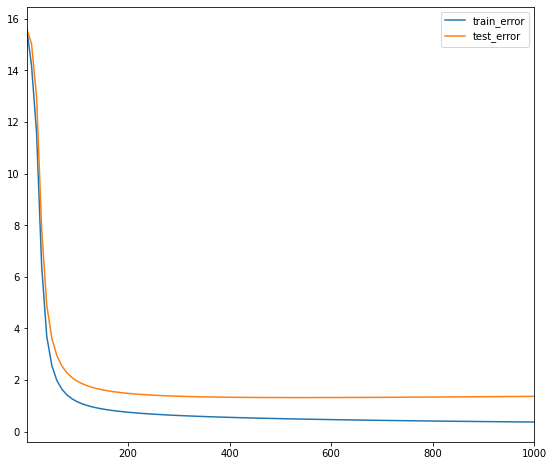

In [31]:
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

In [32]:
DOT = 'dot'
COSINE = 'cosine'

def compute_scores(query_embedding, item_embeddings, measure=DOT):
    """Computes the scores of the candidates given a query.
    Args:
        query_embedding: a vector of shape [k], representing the query embedding.
        item_embeddings: a matrix of shape [N, k], such that row i is the embedding
        of item i.
        measure: a string specifying the similarity measure to be used. Can be
        either DOT or COSINE.
    Returns:
        scores: a vector of shape [N], such that scores[i] is the score of item i.
    """
    u = query_embedding
    V = item_embeddings
    if(measure == COSINE):
        V /= np.linalg.norm(V, axis=1, keepdims=True)
        u /= np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

In [46]:
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
    if USER_RATINGS:
        scores = compute_scores(model.embeddings['user_id'][943], model.embeddings['movie_id'], measure)
        score_key = measure + 'score'
        
        df = pd.DataFrame({
            score_key: list(scores),
            'movie_id': items['movie_id'],
            'titles': items['movie_title'],
            'genres': items['all_genres'],
        })
        if(exclude_rated):
            rated_movies = ratings[ratings.user_id == '943']['movie_id'].values
            df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
        display.display(df.sort_values([score_key], ascending=False).head(k))

In [34]:
def movie_neighbors(model, title_substring, measure=DOT, k=6):
    ids = items[items['movie_title'].str.contains(title_substring)].index.values
    titles = items.iloc[ids]['movie_title'].values
    if(len(titles) == 0):
        raise ValueError('Found no movies with title %s' % title_substring)
    print("Nearest neighbors of: %s" % titles[0])
    if(len(titles) > 1):
        print("[Found more than one matching movie. Other candidates: {}]".format(','.join(titles[1:])))
        movie_id = ids[0]
        scores = compute_scores(
            model.embeddings['movie_id'][movie_id], model.embeddings['movie_id'],
        measure)
        score_key = measure + 'score'
        df = pd.DataFrame({
            score_key: list(scores),
            'titles': items['movie_title'],
            'genres': items['all_genres']
        })
        display.display(df.sort_values([score_key], ascending=False).head(k))

## Movie Embedding Norm  
---

In [35]:
def movie_embedding_norm(models):
    """
    """
    if not isinstance(models, list):
        models = [models]
    df = pd.DataFrame({
        'title': items['movie_title'],
        'genre': items['genre'],
        'num_ratings': movies_ratings['rating count'],
    })
    charts = []
    brush = alt.selection_interval()

    for i, model in enumerate(models):
        norm_key = 'norm'+str(i)
        df[norm_key] = np.linalg.norm(model.embeddings['movie_id'], axis=1)
        nearest = alt.selection(
            type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
            empty='none')
        base = alt.Chart().mark_circle().encode(
            x = 'num_ratings', 
            y = norm_key,
            color = alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
        ).properties(
            selection=nearest).add_selection(brush)
        text = alt.Chart().mark_text(align='center', dx=5, dy=5).encode(
            x='num_ratings', y=norm_key,
            text=alt.condition(nearest, 'title', alt.value('')))
        charts.append(alt.layer(base, text))
    return alt.hconcat(*charts, data=df)

In [36]:
def visualize_movie_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'movie_title', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

In [37]:
def tsne_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["movie_id"])
  items.loc[:,'x'] = V_proj[:, 0]
  items.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(items, 'x', 'y')

In [38]:
movie_embedding_norm(model)

alt.HConcatChart(...)

2021-09-02 09:36:36.160372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-09-02 09:36:36.160421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      


 iteration 1000: train_error=0.352984, test_error=0.972473Nearest neighbors of: Aladdin (1992)
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dotscore                             titles  \
94      5.462                     Aladdin (1992)   
0       4.942                   Toy Story (1995)   
63      4.859   Shawshank Redemption, The (1994)   
95      4.839  Terminator 2: Judgment Day (1991)   
21      4.825                  Braveheart (1995)   
172     4.774         Princess Bride, The (1987)   

                                  genres  
94   Animation_Children's_Comedy_Musical  
0            Animation_Children's_Comedy  
63                                 Drama  
95                Action_Sci-Fi_Thriller  
21                      Action_Drama_War  
172      Action_Adventure_Comedy_Romance

Nearest neighbors of: Aladdin (1992)
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosinescore                                             titles  \
94          1.000                                     Aladdin (1992)   
365         0.841                             Dangerous Minds (1995)   
1284        0.837                            Princess Caraboo (1994)   
1241        0.834  Old Lady Who Walked in the Sea, The (Vieille q...   
753         0.833                                  Red Corner (1997)   
1441        0.833                         Scarlet Letter, The (1995)   

                                   genres  
94    Animation_Children's_Comedy_Musical  
365                                 Drama  
1284                                Drama  
1241                               Comedy  
753                        Crime_Thriller  
1441                                Drama

alt.HConcatChart(...)

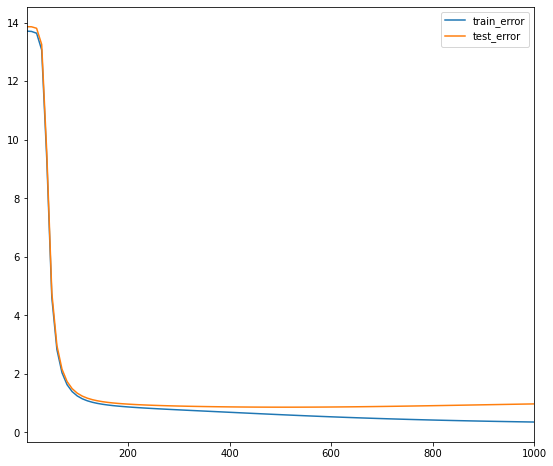

In [39]:
model_lowinit = build_model(ratings, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
movie_neighbors(model_lowinit, 'Aladdin', DOT)
movie_neighbors(model_lowinit, 'Aladdin', COSINE)
movie_embedding_norm([model, model_lowinit])

### Embedding Visualization
---

In [40]:
tsne_movie_embeddings(model_lowinit)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.001s...
[t-SNE] Computed neighbors for 1682 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.119316


/home/daniel/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.383133
[t-SNE] KL divergence after 400 iterations: 2.156801


alt.HConcatChart(...)

## Regularization in Matrix Factorization
---

In [54]:
def gravity(U, V):
    """Creates a gravity loss given two embedding matrices."""
    return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
        tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

In [42]:
def build_regularized_model(ratings, embedding_dim=3, regularization_coeff=.1, 
                            gravity_coeff=1., init_stddev=0.1):
    """
    Args:
        -ratings:
        -embedding_dim:
        -regularization_coef:
        -gravity_coef:
    Returns:
        A CFModel object that uses a regularized loss.
    """
    train_ratings, test_ratings = split_dataframe(ratings)
    A_train =  build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)

    U= tf.Variable(tf.random_normal([A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal([A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

    error_train = sparse_mean_square_error(A_train, U, V)
    error_test = sparse_mean_square_error(A_test, U, V)
    gravity_loss = gravity_coeff * gravity(U, V)
    regularization_loss = regularization_coeff * (
        tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
    total_loss = error_train + regularization_loss + gravity_loss

    losses = {
        'train_error_observed': error_train,
        'test_error_observed' : error_test
    }
    loss_components = {
        'observed_loss': error_train,
        'regularization_loss': regularization_loss,
        'gravity_loss': gravity_loss
    }

    embeddings = {'user_id': U, 'movie_id': V}

    return CFModel(embeddings, total_loss, [losses, loss_components])

2021-09-02 09:36:48.502521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-09-02 09:36:48.502580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      


 iteration 2000: train_error_observed=1.003209, test_error_observed=2.426359, observed_loss=1.003209, regularization_loss=0.852462, gravity_loss=1.317211

[{'train_error_observed': 1.0032089, 'test_error_observed': 2.426359},
 {'observed_loss': 1.0032089,
  'regularization_loss': 0.852462,
  'gravity_loss': 1.3172109}]

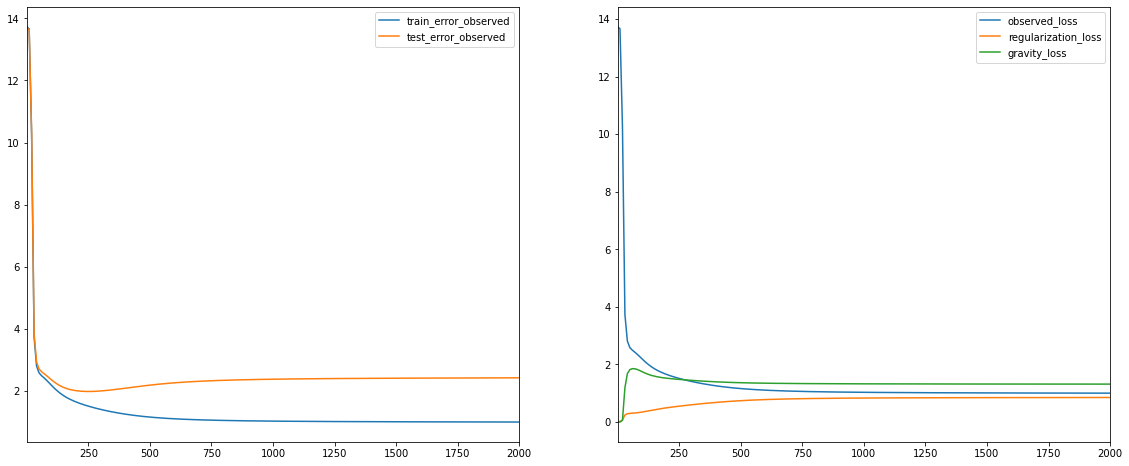

In [43]:
reg_model = build_regularized_model(
    ratings, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

## Inspecting the results
---

In [47]:
user_recommendations(reg_model, DOT, exclude_rated=True, k=10)

In [48]:
movie_neighbors(reg_model, "Aladdin", DOT)
movie_neighbors(reg_model, "Aladdin", COSINE)

Nearest neighbors of: Aladdin (1992)
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dotscore                          titles  \
94      8.965                  Aladdin (1992)   
70      8.164           Lion King, The (1994)   
173     7.509  Raiders of the Lost Ark (1981)   
0       7.452                Toy Story (1995)   
587     7.249     Beauty and the Beast (1991)   
68      7.020             Forrest Gump (1994)   

                                  genres  
94   Animation_Children's_Comedy_Musical  
70          Animation_Children's_Musical  
173                     Action_Adventure  
0            Animation_Children's_Comedy  
587         Animation_Children's_Musical  
68                    Comedy_Romance_War

Nearest neighbors of: Aladdin (1992)
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosinescore                            titles  \
94         1.000                    Aladdin (1992)   
70         0.884             Lion King, The (1994)   
587        0.815       Beauty and the Beast (1991)   
264        0.758  Hunt for Red October, The (1990)   
464        0.743           Jungle Book, The (1994)   
81         0.739              Jurassic Park (1993)   

                                  genres  
94   Animation_Children's_Comedy_Musical  
70          Animation_Children's_Musical  
587         Animation_Children's_Musical  
264                      Action_Thriller  
464         Adventure_Children's_Romance  
81               Action_Adventure_Sci-Fi

In [49]:
movie_embedding_norm([model, model_lowinit, reg_model])

alt.HConcatChart(...)

#### Visualize Embeddings

In [51]:
tsne_movie_embeddings(reg_model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.002s...
[t-SNE] Computed neighbors for 1682 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.251116


/home/daniel/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.197277
[t-SNE] KL divergence after 400 iterations: 1.474980


alt.HConcatChart(...)